In [25]:
from pathlib import Path
import pickle
from time import time
from typing import List, Dict, Set, Tuple
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.datasets import load_iris
import numpy as np
import gensim
import networkx as nx
from node2vec import Node2Vec
from sklearn.decomposition import PCA
from ge.classify import read_node_label, Classifier
from ge import LINE
from sklearn.linear_model import LogisticRegression
from tensorflow import keras
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import tensorflow as tf
from gensim import utils
from numpy import float32 as REAL


In [2]:
class GraphLoader:
    def __init__(self):
        self.graph = None
        self.title = None
        
    def build_graph(self, 
                    dataframe: pd.DataFrame, 
                    columns: List, 
                    edge_list: List,
                    verbose: bool = True,
                    title: str = 'Unnamed'):
        self.title = title
        t0 = time()
        self.graph = nx.Graph(name = self.title)

        # Add Nodes to the graph.
        for column in columns:
            self.graph.add_nodes_from(dataframe[column].values, label=column)

        # Add remaining columns as Node attributes. Optional
        remaining = dataframe.columns.difference(columns)
        for node, data in self.graph.nodes(data=True):
            if data["label"] == "K":
                self.graph.nodes[node]["K"] = dataframe.loc[dataframe["K"] == int(node), remaining].squeeze().to_dict()

        # Add Edges.
        for _, row in dataframe.loc[:, columns].iterrows():
            for edge in edge_list:
                self.graph.add_edge(row[edge[0]], row[edge[1]])
        
        if verbose:
            print(f"FINISHED in {np.round(time() - t0, 3)} seconds.")
            print(nx.info(self.graph))
        
        return self.graph

    def draw_graph(self, graph: nx.Graph, node_colors: dict, node: str = None, radius: int = 1) -> None:
        def assign_colors(graph: nx.Graph) -> List:
            # Assign Colors to nodes
            colors = []
            for n, data in graph.nodes(data=True):
                node = data["label"]
                colors.append(node_colors.get(node, "white"))
            return colors

        f = plt.figure(figsize = (20,12), facecolor="darkgray")
        ax = f.add_subplot()

        if not node:    
            plt.title(self.title)
        else:
            plt.title(f"Ego Graph around the node {node}, (radius={radius})")
            graph = nx.ego_graph(graph, node, radius = radius)
        
        colors = assign_colors(graph)
        nx.draw_networkx(graph, node_size = 300, node_color = colors, with_labels = False)
        # Add an empty plot to set custom legends
        from matplotlib.lines import Line2D
        ax.scatter([],[])
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='K', markerfacecolor = node_colors['K'], markersize=15),
            Line2D([0], [0], marker='o', color='w', label='S1', markerfacecolor = node_colors['S1'], markersize=10),
            Line2D([0], [0], marker='o', color='w', label='S2', markerfacecolor = node_colors['S2'], markersize=10),
            Line2D([0], [0], marker='o', color='w', label='S3', markerfacecolor = node_colors['S3'], markersize=10),
            Line2D([0], [0], marker='o', color='w', label='S4', markerfacecolor = node_colors['S4'], markersize=10),
            Line2D([0], [0], marker='o', color='w', label='S5', markerfacecolor = node_colors['S5'], markersize=10),
            Line2D([0], [0], marker='o', color='w', label='S6', markerfacecolor = node_colors['S6'], markersize=10),

        ]
        ax.legend(handles=legend_elements, loc='best')
        plt.show()

In [3]:
attrition_data = 'cbd.csv'
df_attrition = pd.read_csv(attrition_data)
target_column = 'word'
selected_columns = ['K', 'S1', 'S2', 'S3', \
                    'S4', 'S5','S6']

df_attrition = df_attrition.loc[:, selected_columns]

In [4]:
attrition = 'test.csv'
df_ac = pd.read_csv(attrition,encoding='utf-8')

In [5]:
nodes = selected_columns[:] # Do not select Attrition as a feature node
edges = [("K","S1"),
         ("K","S2"),
         ("K","S3"),
         ("K","S4"),
         ("K","S5"),
         ("K","S6")]

node_colors = { # freestyle, update any color.
    "K": "dodgerblue", 
    "S1":"lightgreen", 
    "S2":"tan", 
    "S3":"salmon",
    "S4":"darkcyan",
    "S5":"lightblue",
    "S6":"yellow"
}

FINISHED in 0.082 seconds.
Graph named 'Multilingual Out of Vocabulary Terms relationship' with 502 nodes and 693 edges


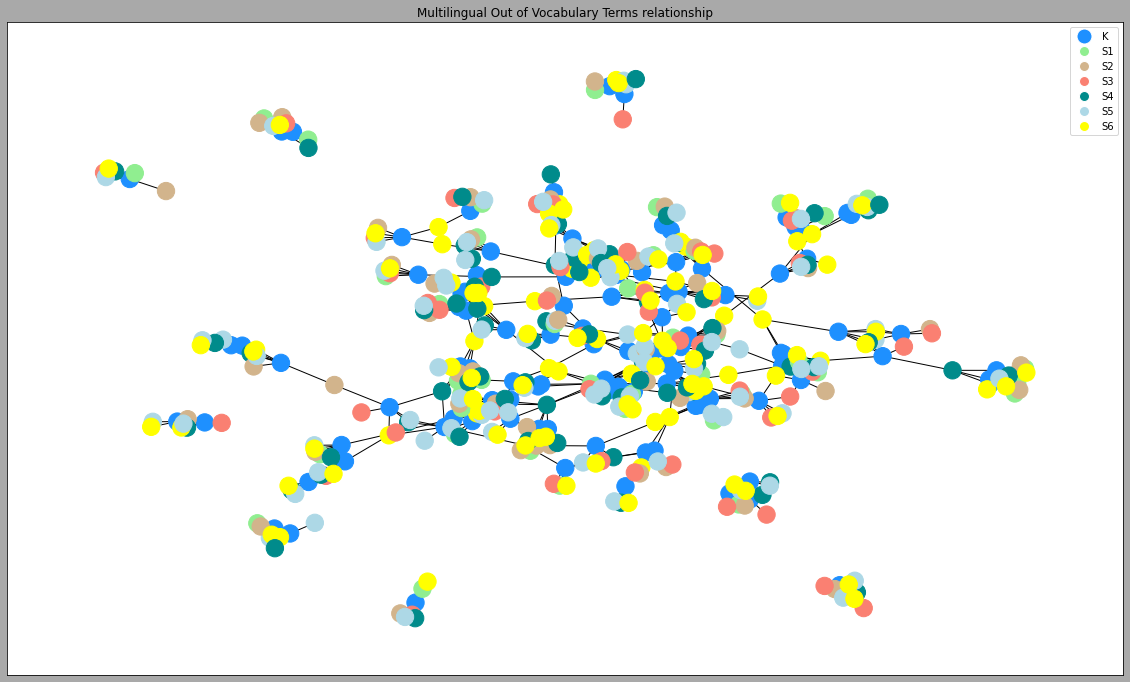

In [6]:
graph_loader = GraphLoader()
demo_graph = graph_loader.build_graph(
            dataframe = df_attrition.loc[:, selected_columns[:]],
            columns = nodes, 
            edge_list = edges,
            verbose = True,
            title = 'Multilingual Out of Vocabulary Terms relationship'
        )
# graph_loader.draw_graph(demo_graph, node_colors, node = 5, radius = 2) # show only the nodes that are at a distance of 2 edges from the employee 5.
graph_loader.draw_graph(demo_graph, node_colors) # Show the whole graph

## Line


In [26]:
CWD = Path().cwd()
EMBEDDINGS_DIR = CWD / 'embeddings'
EMBEDDINGS_DIR.mkdir(parents=True, exist_ok=True)
SEED = 12

class Line_VectorizerConfig:
    dimensions = 128
    walk_length = 30
    num_walks = 50
    window = 10
    min_count = 1
    batch_words = 100

class Line_NodeEmbedding:

    def __init__(self) -> None:
        self.vectorizer = None
        self.model = None
        
    def generate_random_walks(self, graph: nx.Graph, **params) -> None:
        self.vectorizer = LINE(graph, **params)
        # return self.vectorizer

    def fit(self, **params) -> tf.keras.models:
        if self.vectorizer is None:
            raise Exception("No random walks. Generate Random walks by calling generate_random_walks() method first.")
        self.vectorizer.train(**params)
        self.model= self.vectorizer.get_embeddings()
        return self.model
    def save_model(self, model: gensim.models.Word2Vec, save_to: Path = EMBEDDINGS_DIR, prefix: str = None) -> None:
        m = gensim.models.keyedvectors.Word2VecKeyedVectors(vector_size=Line_VectorizerConfig.dimensions)
        m.add_vectors(list(self.model.keys()), list(self.model.values())) 
        d = Line_VectorizerConfig.dimensions
        w = Line_VectorizerConfig.walk_length
        n = Line_VectorizerConfig.num_walks
        embeddings_filename = f"{prefix}_embeddings_{d}_{w}_{n}_line.txt"
        model_filename = f"{prefix}_model_{d}_{w}_{n}_line.pkl"
        # Save only the embeddings in a txt file.
        m.save_word2vec_format(str(EMBEDDINGS_DIR/embeddings_filename))
        # Save the entire model.
        m.save(str(EMBEDDINGS_DIR/model_filename))
        print(f"Model and embeddings saved to: {str(EMBEDDINGS_DIR/model_filename)}")
    def load_model(self, model_filename: str = None, load_from: Path = EMBEDDINGS_DIR) -> gensim.models.Word2Vec:
        if Path(EMBEDDINGS_DIR / model_filename).exists():
            print("Loaded Model: ", model_filename)
            with Path(EMBEDDINGS_DIR / model_filename).open(mode="r+b") as file:
                self.model = pickle.load(file)
        else:
            raise FileNotFoundError(f"NOT found: {EMBEDDINGS_DIR / model_filename}")
        
        return self.model



In [208]:
import multiprocessing

embedder = Line_NodeEmbedding()

In [ ]:
embedder.generate_random_walks(
    demo_graph,
    embedding_size = Line_VectorizerConfig.dimensions,
    order='second'
)

model = embedder.fit(
    verbose = Line_VectorizerConfig.min_count,
    epochs = Line_VectorizerConfig.num_walks,
    batch_size = Line_VectorizerConfig.batch_words
)

In [210]:
embedder.save_model(model, save_to = EMBEDDINGS_DIR, prefix = "K")

Model and embeddings saved to: c:\Users\Administrator\Dropbox\毕业论文\实验\embeddings\K_model_128_30_50_line.pkl


In [212]:
model2 = embedder.load_model(r"K_model_128_30_50_line.pkl", load_from = EMBEDDINGS_DIR)

Loaded Model:  K_model_128_30_50_line.pkl


In [214]:
with open(r'embeddings\K_embeddings_128_30_50_line.txt', 'r',encoding='UTF-8') as embeddings_file:
    embeddings = embeddings_file.readlines()

In [215]:
embeddings[:1]

['502 128\n']

In [30]:
# This function is requred since embeddings are out of order with the target. They were not matched correctly.
def align_features_and_target(df: pd.DataFrame, embeddings_file: str = None):
    vectors = []
    with Path(EMBEDDINGS_DIR / embeddings_file).open(mode="r",encoding='UTF-8') as file:
        results = file.readlines()
        for person in df["K"].values:
            for line in results[1:]:
                if line.split()[0] == str(person):
                    vectors.append(line.split()[1:])
    
    return np.array(vectors).astype(np.float64)

In [217]:
%%time
embeddings_filename = r"K_embeddings_128_30_50_line.txt"
feature_vectors = align_features_and_target(df_attrition, embeddings_file = embeddings_filename)

Wall time: 1.01 s


In [218]:
feature_vectors.shape

(116, 128)

In [219]:
node_targets = np.array(list(map(lambda label: 1 if label == "Yes" else 0, df_attrition["K"])))
# node_targets = df_attrition_encoded['Attrition'].values
node_targets.shape


(116,)

In [34]:
def func(*kargs): return kargs
def rec(S,model):
    print('~'*20)
    s=S
    a=model.similar_by_word(s)
    b=[]
    
    for i in range(len(a)):
        try:
            b.append([int(a[i][0]),a[i][1]])
        except ValueError:
            p=1
    c=[]
    for d in range(len(b)):
        c.append(str(df_ac.loc[df_ac['K']==b[d][0]]['word'].values[0]))
    print(str(s)+'.'+df_ac.loc[df_ac['K']==s]['word'].values[0]+str(c))

In [235]:
for i in range(1,117):
    rec(i,model2)

~~~~~~~~~~~~~~~~~~~~
1.백신패스['ワクチンパスポト', '위드코로나', '健康码', 'ウィズコロナ', '독박육아', '走花路', '刷屏', 'マルチ', '完成接种人员', '報復消費']
~~~~~~~~~~~~~~~~~~~~
2.위드코로나['ウィズコロナ', '奥密克戎毒株', '完成接种人员', '段階日常回復', '접종완료자', '백신패스', 'ヒンナムノー', '독박육아', 'モッパン', '핑프']
~~~~~~~~~~~~~~~~~~~~
3.접종완료자['完成接种人员', '위드코로나', '奥密克戎毒株', 'ウィズコロナ', '报复性消费', '静かな退職', '走花路', '독박육아', '재택근무', '백신패스']
~~~~~~~~~~~~~~~~~~~~
4.ウィズコロナ['위드코로나', '段階日常回復', '奥密克戎毒株', '접종완료자', '完成接种人员', '백신패스', '핑프', 'ヒンナムノー', 'オミクロン', '报复性消费']
~~~~~~~~~~~~~~~~~~~~
5.段階日常回復['ウィズコロナ', '위드코로나', 'ヒンナムノー', '网课大学', '奥密克戎毒株', '在宅勤務', '静かな退職', '만잘부', '完成接种人员', '吃播']
~~~~~~~~~~~~~~~~~~~~
6.ワクチンパスポト['백신패스', 'ウィズコロナ', '健康码', '居家', '报复性消费', '당모치', '접종완료자', '荒らし', '위드코로나', '完成接种人员']
~~~~~~~~~~~~~~~~~~~~
7.内卷['노오력', '관둠', '위드코로나', '人流', '재택근무', '静かな退職', '躺平', '伸手党', '自宅療養', '废柴老公']
~~~~~~~~~~~~~~~~~~~~
8.노오력['内卷', '재택근무', '위드코로나', '静かな退職', '人流', '恐妻家', '관둠', '伸手党', '냥집사', '在宅勤務']
~~~~~~~~~~~~~~~~~~~~
9.道路族['自宅療養', '위드코로나', '백신패스', '报复性消费', '자택치료', '접종완료자', 'マルチ', '젠더평등', '完成接种人员',

## Deepwalk

In [24]:
import numpy as np

from ge.classify import read_node_label, Classifier
from ge import DeepWalk
from sklearn.linear_model import LogisticRegression
CWD = Path().cwd()
EMBEDDINGS_DIR = CWD / 'embeddings'
EMBEDDINGS_DIR.mkdir(parents=True, exist_ok=True)
SEED = 12

class dw_VectorizerConfig:
    dimensions = 128
    walk_length = 100
    num_walks = 50
    window = 10
    min_count = 1
    batch_words = 100

class dw_NodeEmbedding:

    def __init__(self) -> None:
        self.vectorizer = None
        self.model = None
        
    def generate_random_walks(self, graph: nx.Graph, **params) -> None:
        self.vectorizer = DeepWalk(graph, **params)
        # return self.vectorizer

    def fit(self, **params) -> tf.keras.models:
        if self.vectorizer is None:
            raise Exception("No random walks. Generate Random walks by calling generate_random_walks() method first.")
        self.vectorizer.train(**params)
        self.model= self.vectorizer.get_embeddings()
        return self.model
    def save_model(self, model: gensim.models.Word2Vec, save_to: Path = EMBEDDINGS_DIR, prefix: str = None) -> None:
        m = gensim.models.keyedvectors.Word2VecKeyedVectors(vector_size=dw_VectorizerConfig.dimensions)
        m.add_vectors(list(self.model.keys()), list(self.model.values())) 
        d = dw_VectorizerConfig.dimensions
        w = dw_VectorizerConfig.walk_length
        n = dw_VectorizerConfig.num_walks
        embeddings_filename = f"{prefix}_embeddings_{d}_{w}_{n}_deepwalk.txt"
        model_filename = f"{prefix}_model_{d}_{w}_{n}_deepwalk.pkl"
        # Save only the embeddings in a txt file.
        m.save_word2vec_format(str(EMBEDDINGS_DIR/embeddings_filename))
        # Save the entire model.
        m.save(str(EMBEDDINGS_DIR/model_filename))
        print(f"Model and embeddings saved to: {str(EMBEDDINGS_DIR/model_filename)}")
    def load_model(self, model_filename: str = None, load_from: Path = EMBEDDINGS_DIR) -> gensim.models.Word2Vec:
        if Path(EMBEDDINGS_DIR / model_filename).exists():
            print("Loaded Model: ", model_filename)
            with Path(EMBEDDINGS_DIR / model_filename).open(mode="r+b") as file:
                self.model = pickle.load(file)
        else:
            raise FileNotFoundError(f"NOT found: {EMBEDDINGS_DIR / model_filename}")
        
        return self.model



NameError: name 'tf' is not defined

In [19]:
import multiprocessing
embedder2 = dw_NodeEmbedding()

In [22]:
model3 = embedder2.load_model(r"K_model_128_30_50_deepwalk.pkl", load_from = EMBEDDINGS_DIR)
with open(r'embeddings/K_embeddings_128_30_50_deepwalk.txt', 'r',encoding='UTF-8') as embeddings_file:
    embeddings = embeddings_file.readlines()

Loaded Model:  K_model_128_30_50_deepwalk.pkl


In [25]:
%%time
embeddings_filename = r"K_embeddings_128_30_50_deepwalk.txt"
feature_vectors = align_features_and_target(df_attrition, embeddings_file = embeddings_filename)

CPU times: user 655 ms, sys: 16.2 ms, total: 672 ms
Wall time: 671 ms


In [26]:
node_targets = np.array(list(map(lambda label: 1 if label == "Yes" else 0, df_attrition["K"])))
# node_targets = df_attrition_encoded['Attrition'].values
node_targets.shape

(116,)

In [30]:
for i in range(1,117):
    rec(i,model3)

~~~~~~~~~~~~~~~~~~~~
1.백신패스['健康码']
~~~~~~~~~~~~~~~~~~~~
2.위드코로나['ウィズコロナ', '段階日常回復']
~~~~~~~~~~~~~~~~~~~~
3.접종완료자['完成接种人员', '위드코로나']
~~~~~~~~~~~~~~~~~~~~
4.ウィズコロナ['위드코로나', '段階日常回復']
~~~~~~~~~~~~~~~~~~~~
5.段階日常回復['ウィズコロナ', '위드코로나']
~~~~~~~~~~~~~~~~~~~~
6.ワクチンパスポト['백신패스', '健康码']
~~~~~~~~~~~~~~~~~~~~
7.内卷['노오력', '吃瓜', '無策政府']
~~~~~~~~~~~~~~~~~~~~
8.노오력['内卷', '吃瓜']
~~~~~~~~~~~~~~~~~~~~
9.道路族['ヒンナムノー']
~~~~~~~~~~~~~~~~~~~~
10.無策政府['가학방역']
~~~~~~~~~~~~~~~~~~~~
11.가학방역['無策政府']
~~~~~~~~~~~~~~~~~~~~
12.原生家庭['親ガチャ']
~~~~~~~~~~~~~~~~~~~~
13.親ガチャ['原生家庭']
~~~~~~~~~~~~~~~~~~~~
14.자택치료['居家', '自宅療養']
~~~~~~~~~~~~~~~~~~~~
15.自宅療養['居家', '자택치료']
~~~~~~~~~~~~~~~~~~~~
16.居家['自宅療養', '자택치료']
~~~~~~~~~~~~~~~~~~~~
17.健康码['백신패스']
~~~~~~~~~~~~~~~~~~~~
18.数媒土著['MZ세대', 'Z世代']
~~~~~~~~~~~~~~~~~~~~
19.Z世代['数媒土著', 'MZ세대']
~~~~~~~~~~~~~~~~~~~~
20.MZ세대['数媒土著', 'Z世代']
~~~~~~~~~~~~~~~~~~~~
21.관둠['静かな退職', '躺平']
~~~~~~~~~~~~~~~~~~~~
22.静かな退職['관둠', '躺平']
~~~~~~~~~~~~~~~~~~~~
23.躺平['관둠', '静かな退職']
~~~~~~~~~~~~~~~~~~~~
24.完成接种人

## SDNE

In [10]:
from ge.models.sdne import SDNE
from ge.base import MultiClassifier
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np


In [12]:
model4 = SDNE(demo_graph, hidden_layers=[256, 128])

In [14]:
model4.fit(batch_size=100, epochs=50)

########## regulations weight ##########
encoder.0.weight
encoder.2.weight
decoder.0.weight
decoder.2.weight
#########################
Epoch 1, loss 0.148 . >>> Epoch 1/50
Epoch 2, loss 0.1993 . >>> Epoch 2/50
Epoch 3, loss 0.1498 . >>> Epoch 3/50
Epoch 4, loss 0.155 . >>> Epoch 4/50
Epoch 5, loss 0.151 . >>> Epoch 5/50
Epoch 6, loss 0.1475 . >>> Epoch 6/50
Epoch 7, loss 0.1458 . >>> Epoch 7/50
Epoch 8, loss 0.1452 . >>> Epoch 8/50
Epoch 9, loss 0.1446 . >>> Epoch 9/50
Epoch 10, loss 0.1441 . >>> Epoch 10/50
Epoch 11, loss 0.1438 . >>> Epoch 11/50
Epoch 12, loss 0.1435 . >>> Epoch 12/50
Epoch 13, loss 0.1432 . >>> Epoch 13/50
Epoch 14, loss 0.143 . >>> Epoch 14/50
Epoch 15, loss 0.1429 . >>> Epoch 15/50
Epoch 16, loss 0.1428 . >>> Epoch 16/50
Epoch 17, loss 0.1427 . >>> Epoch 17/50
Epoch 18, loss 0.1426 . >>> Epoch 18/50
Epoch 19, loss 0.1425 . >>> Epoch 19/50
Epoch 20, loss 0.1424 . >>> Epoch 20/50
Epoch 21, loss 0.1424 . >>> Epoch 21/50
Epoch 22, loss 0.1425 . >>> Epoch 22/50
Epoch 2

In [16]:
embeddings = model4.get_embeddings()

In [22]:
CWD = Path().cwd()
EMBEDDINGS_DIR = CWD / 'embeddings'
EMBEDDINGS_DIR.mkdir(parents=True, exist_ok=True)
SEED = 12
def save_model(model: gensim.models.Word2Vec, save_to: Path = EMBEDDINGS_DIR, prefix: str = None) -> None:
        m = gensim.models.keyedvectors.Word2VecKeyedVectors(vector_size=128)
        m.add_vectors(list(model.keys()), list(model.values())) 
        d = 128
        w = 30
        n = 50
        embeddings_filename = f"{prefix}_embeddings_{d}_{w}_{n}_sdne.txt"
        model_filename = f"{prefix}_model_{d}_{w}_{n}_sdne.pkl"
        # Save only the embeddings in a txt file.
        m.save_word2vec_format(str(EMBEDDINGS_DIR/embeddings_filename))
        # Save the entire model.
        m.save(str(EMBEDDINGS_DIR/model_filename))
        print(f"Model and embeddings saved to: {str(EMBEDDINGS_DIR/model_filename)}")

In [23]:
save_model(embeddings, save_to = EMBEDDINGS_DIR, prefix = "K")

Model and embeddings saved to: /home/gujiakai/Dropbox/毕业论文/实验/embeddings/K_model_128_30_50_sdne.pkl


In [27]:
import multiprocessing

embedder = Line_NodeEmbedding()

In [28]:
model5 = embedder.load_model(r"K_model_128_30_50_sdne.pkl", load_from = EMBEDDINGS_DIR)
with open(r'embeddings/K_embeddings_128_30_50_sdne.txt', 'r',encoding='UTF-8') as embeddings_file:
    embeddings = embeddings_file.readlines()

Loaded Model:  K_model_128_30_50_sdne.pkl


In [31]:
%%time
embeddings_filename = r"K_embeddings_128_30_50_sdne.txt"
feature_vectors = align_features_and_target(df_attrition, embeddings_file = embeddings_filename)

CPU times: user 677 ms, sys: 7.66 ms, total: 685 ms
Wall time: 682 ms


In [35]:
for i in range(1,117):
    rec(i,model5)

~~~~~~~~~~~~~~~~~~~~
1.백신패스['健康码', 'ワクチンパスポト', 'ポストコロナ', 'ウィズコロナ', '접종완료자', '위드코로나', '后疫情时代', '完成接种人员', '報復消費', '보복소비']
~~~~~~~~~~~~~~~~~~~~
2.위드코로나['ウィズコロナ', '段階日常回復', '完成接种人员', '접종완료자', '백신패스', '健康码', 'ワクチンパスポト', '花の道', '미접종자', '메타버스']
~~~~~~~~~~~~~~~~~~~~
3.접종완료자['完成接种人员', 'マルチ', 'ワクチンパスポト', '健康码', '위드코로나', '백신패스', 'ウィズコロナ', '비담', '颜值担当', '玻璃心']
~~~~~~~~~~~~~~~~~~~~
4.ウィズコロナ['위드코로나', '段階日常回復', '完成接种人员', '백신패스', '健康码', '접종완료자', 'ワクチンパスポト', '花の道', '미접종자', 'ヒンナムノー']
~~~~~~~~~~~~~~~~~~~~
5.段階日常回復['ウィズコロナ', '위드코로나', 'オミクロン', '奥密克戎毒株', '完成接种人员', '젠더평등', '原生家庭', '后疫情时代', 'ポストコロナ', '网课大学']
~~~~~~~~~~~~~~~~~~~~
6.ワクチンパスポト['백신패스', '健康码', '접종완료자', '完成接种人员', '위드코로나', 'ウィズコロナ', '玻璃心', '废柴老公', 'ウェビナー', '奥密克戎毒株']
~~~~~~~~~~~~~~~~~~~~
7.内卷['노오력', '인파', '面食い', '计划人生', '恐妻家', '위드코로나', '颜值担当', '비담', '메타버스', '妈虫']
~~~~~~~~~~~~~~~~~~~~
8.노오력['内卷', '铲屎官', '관둠', '냥집사', '网课大学', '愛猫家', 'ウィズコロナ', '위드코로나', '黙トレ', '인파']
~~~~~~~~~~~~~~~~~~~~
9.道路族['ヒンナムノー', 'メタバース', '줌유니버시티', '面食い', '花の道', '메타버스', '위드코로나', '꽃길'